This notebook demonstrates how to subtract the dome-shaped background from the detector image
with minimal impact on the residual sources (if any).

The method should be used after the last IROS iteration, to estimate the background from the residual image and subtract it
from the original (i.e. acquired) detector image.
After that, IROS can be re-started from the beginning.
This will allow for a better estimation of the source fluxes and positions and will also make possible to go deeper in the
noise.

In [1]:
%matplotlib ipympl
import numpy as np
from mask_utils import *
import matplotlib.pyplot as plt
from matplotlib import cm

In [2]:
mask, hdmask = read_mask_bulk('wfm_mask.fits', 2, header_out=True, verbose=False)
rmatrix = read_mask_bulk('wfm_mask.fits', 3, verbose=False)
bulk = read_mask_bulk('wfm_mask.fits', 4, verbose=False)

In [3]:
#Removing fractional bulk elements to simplify the analysis
bulk[bulk < 1] = 0

In [4]:
#Gets mask information and define X, Y vectors (centers and edges)
ELXDIM = hdmask['ELXDIM'] 
ELYDIM = hdmask['ELYDIM'] 
ELXN   = hdmask['ELXN'] 
ELYN   = hdmask['ELYN'] 

In [5]:
#Defines FITS event file
#fdet = "cxb_2-50keV_10ks_infthinmask_cam1a_detected.fits"
fdet = "cxb_2-50keV_10ks_cam1a_detected.fits"


In [6]:
det, hdet0, hdet1 = read_fits_events(fdet, header0=True, header1=True, verbose=False)
xedges, yedges = get_detimage_edges(ELXDIM, ELYDIM, ELXN, ELYN)

#Computes detector image
detimage = get_detimage(det, xedges, yedges) * bulk

#Add a weak fake off-axis source
srate = 0.2
sshift = ( int(detimage.shape[0] * 0.5), int(detimage.shape[1] * 0.5))
sourceimage = fshift(np.random.poisson(lam=srate, size=detimage.shape) * mask, -sshift[0], -sshift[1] ) * bulk

detimage += sourceimage

In [7]:
# Now we estimate the background shape

from scipy import ndimage

# First we "collapse" the detector image on the two directions independently
detcollapsed_y = detimage.sum(axis=0)
detcollapsed_x = detimage.sum(axis=1)

# And we do the same for the bulk
bulkcollapsed_y = bulk.sum(axis=0)
bulkcollapsed_x = bulk.sum(axis=1)

# We then apply a median filter to remove residual high frequencies. 
# A kernel of 7x11 (x0.25mm, x0.4mm) seems good for weak sources (should be the case a the last IROS iteration)
# The median filter is applied "ignoring" the bulk zeros to avoi boundary effects
appo_y = ndimage.median_filter(detcollapsed_y[bulkcollapsed_y>0], size=7, mode='nearest') #with upscaling 1!
appo_x = ndimage.median_filter(detcollapsed_x[bulkcollapsed_x>0], size=11, mode='nearest') #with upscaling 1!

# Then the bulk zeoes are restored 
filtered_y = np.ones(detcollapsed_y.shape)*detcollapsed_y
filtered_y[detcollapsed_y>0] = appo_y
filtered_x = np.ones(detcollapsed_x.shape)*detcollapsed_x
filtered_x[detcollapsed_x>0] = appo_x

# We now create 2 2D arrays and multiply them element by element (always masking with bulk, just to be sure)
filtered_x_2d = (np.tile(filtered_x, (650,1))).T
filtered_y_2d = (np.tile(filtered_y, (1040, 1)))
filtered_2d = filtered_x_2d * filtered_y_2d * bulk

# Eventually, we rescale the array to have the same counts of the original detector image
# Of course (unfortunately) this will contain both bkg and residual sources, but has been tested
# with sources between 5 and 50 sigmas both on-axis and off-axis. Source significance reduction 
# is < 10% 
filtered_2d /= np.sum(detimage)

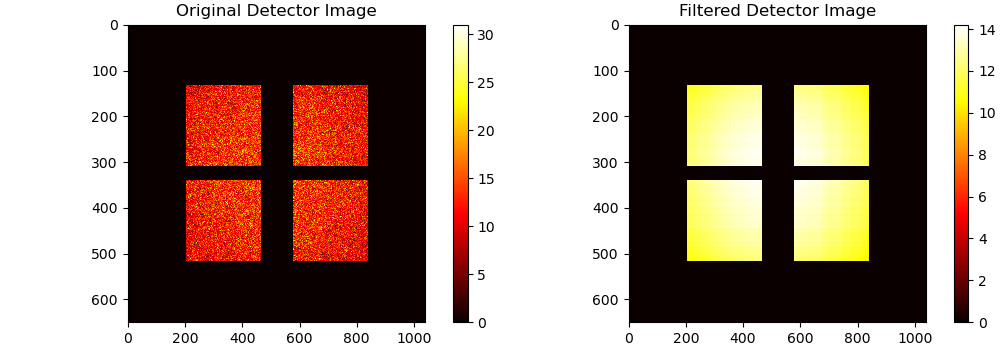

In [8]:
# Plotting original and filtered detector images

fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(10, 3.5))
#Showing detimage
ax[0].set_title("Original Detector Image")
im = ax[0].imshow(detimage.T, cmap=cm.hot,  interpolation='nearest', aspect=ELYDIM/ELXDIM)
cbar = fig.colorbar(im, ax=ax[0])

#Showing filtered detector image
ax[1].set_title("Filtered Detector Image")
im = ax[1].imshow(filtered_2d.T, cmap=cm.hot,  interpolation='nearest', aspect=ELYDIM/ELXDIM)
cbar = fig.colorbar(im, ax=ax[1])
plt.show()

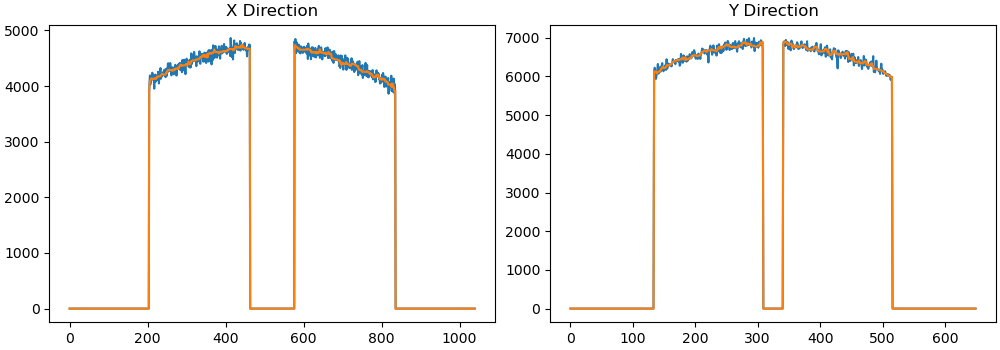

In [9]:
# Plotting collapsed projections

fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(10, 3.5))
axs[0].set_title('X Direction')
axs[0].plot(detcollapsed_x)
axs[0].plot(filtered_x)

axs[1].set_title('Y Direction')
axs[1].plot(detcollapsed_y)
axs[1].plot(filtered_y)
plt.show()

In [10]:
# Now we compute the sky images for:
#    * the original detector image
#    * the backgroung-shaped detector image (filtered)
#    * the detector image after the background subtraction

skyimage = decode(detimage, rmatrix, bulk) 
skyfilt = decode(filtered_2d, rmatrix, bulk) 
skydiff = decode( (detimage - filtered_2d), rmatrix, bulk)

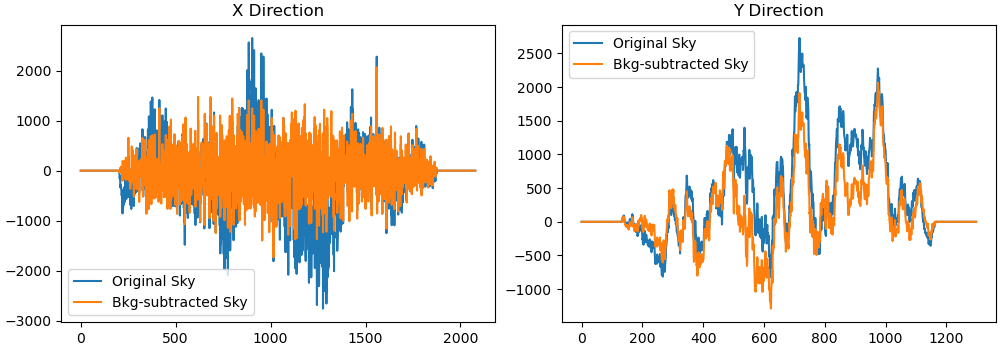

In [11]:
# Plotting Sky images pre and post filtering
# (slices on the weak source position)

s = (sshift[0] + 1039, sshift[1] + 650)

fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(10, 3.5))

axs[0].set_title('X Direction')
axs[0].plot(skyimage[:, s[1]], label="Original Sky")
axs[0].plot(skydiff[:, s[1]], label="Bkg-subtracted Sky")
axs[0].legend()

axs[1].set_title('Y Direction')
axs[1].plot(skyimage[s[0], : ], label="Original Sky")
axs[1].plot(skydiff[s[0]+0, : ], label="Bkg-subtracted Sky")
axs[1].legend()

plt.show()


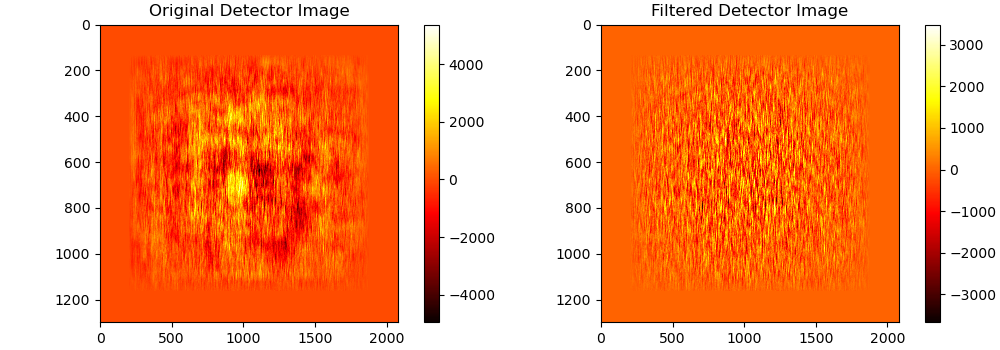

In [12]:
# Plotting original and filtered 2D sky images

fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(10, 3.5))
#Showing detimage
ax[0].set_title("Original Detector Image")
im = ax[0].imshow(skyimage.T, cmap=cm.hot,  interpolation='nearest', aspect=ELYDIM/ELXDIM)
cbar = fig.colorbar(im, ax=ax[0])

#Showing filtered detector image
ax[1].set_title("Filtered Detector Image")
im = ax[1].imshow(skydiff.T, cmap=cm.hot,  interpolation='nearest', aspect=ELYDIM/ELXDIM)
cbar = fig.colorbar(im, ax=ax[1])
plt.show()

In [13]:
# Last we calculate the significance distributions in both cases

var_bal = decode_var(detimage, rmatrix, bulk, 202.9, ELXDIM, ELYDIM)
var_bal_clipped =  np.clip(var_bal, a_min=1E-8, a_max=np.sum(detimage)) if np.any(var_bal <= 0) else var_bal

skysign_original = skyimage/np.sqrt(var_bal_clipped)
skysign_filt_collapse = skydiff/np.sqrt(var_bal_clipped)

# Filtering borders...
skysign_original_cut = skysign_original[205:-205, 134:-134 ]
skysign_filt_collapse_cut = skysign_filt_collapse[205:-205, 134:-134 ]

0.2709373611342182 -0.031985725972653846 1.4679466632205898
0.40201880388459704 9.409130646116968e-05 0.991590057720273


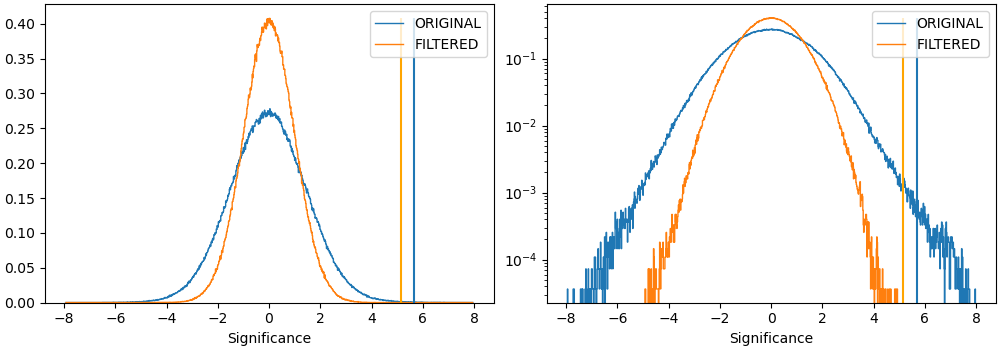

Original source significance 5.6725813962209655
Source significance after bkg sub 5.145613440569114


In [14]:
# And now we fit the residual pre and post bkg subtraction

from scipy.optimize import curve_fit
def gauss(x, A, x0, sigma):
    return A * np.exp(-(x - x0)**2 / (2 * sigma**2))



hsign_original, bins = np.histogram(skysign_original_cut, bins=1000,  density=True)
hsign_collapse, _ = np.histogram(skysign_filt_collapse_cut, bins=bins,  density=True)
binscenters = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])

popt_original, _ = curve_fit(gauss, xdata=binscenters, ydata=hsign_original, p0=[1, 0, 1.0])
popt_collapse, _ = curve_fit(gauss, xdata=binscenters, ydata=hsign_collapse, p0=[1, 0, 1.0])

print(*popt_original)
print(*popt_collapse)

fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(10, 3.5))

axs[0].stairs(hsign_original, bins, label="ORIGINAL")
axs[0].vlines(skysign_original[s], 0,np.max(hsign_collapse))
axs[0].stairs(hsign_collapse, bins, label="FILTERED")
axs[0].vlines(skysign_filt_collapse[s], 0,np.max(hsign_collapse), color="orange")
axs[0].set_xlabel("Significance")
axs[0].legend()


axs[1].stairs(hsign_original, bins, label="ORIGINAL")
axs[1].vlines(skysign_original[s], 0,np.max(hsign_collapse))
axs[1].stairs(hsign_collapse, bins, label="FILTERED")
axs[1].vlines(skysign_filt_collapse[s], 0,np.max(hsign_collapse), color="orange")
axs[1].set_yscale("log")
axs[1].set_xlabel("Significance")
axs[1].legend()
plt.show()


print("Original source significance", skysign_original[s])
print("Source significance after bkg sub", skysign_filt_collapse[s])


The plot above shows that, although the filtering causes a reduction in the source significance of ~10%
(note that for more significant sources the reduction is less important), it allows anyway to make detectable sources that
would be drowned in the noise otherwise.